In [1]:
import paths
import numpy as np
from data_utils import load_yaml_file
import os
from itertools import product

In [2]:
print(os.path.join(paths.TUNE_CONFIGS_PATH, "hyperparameters.yaml"))

c:\Users\biberd\Documents\SurfaceEvents\Story 9999\timeVAE\src\config\tune_configs\hyperparameters.yaml\hyperparameters.yaml


In [3]:
def generate_hyperparameter_list(config):
    """
    Generate a list of hyperparameter configurations from the provided config.

    Args:
        config (dict): Configuration dictionary containing hyperparameters.

    Returns:
        list: A list of hyperparameter dictionaries.
    """
    hyperparameter_list = []
    for key, value in config.items():
        if isinstance(value, list):
            for v in value:
                hyperparameter_list.append({key: v})
        else:
            hyperparameter_list.append({key: value})
    
    return hyperparameter_list

In [5]:
hyperparameters = load_yaml_file(os.path.join(paths.TUNE_CONFIGS_PATH))

In [6]:
param_dict = hyperparameters["vae_conv"]

keys = list(param_dict)
value_lists = list(param_dict.values())

dicts = [dict(zip(keys, values)) for values in product(*value_lists)]

In [7]:
len(dicts)

48

In [8]:
hyperparameters

{'vae_conv': {'latent_dim': [32, 64],
  'hidden_layer_sizes': [[48, 96, 192], [64, 128, 256], [16, 32, 64]],
  'reconstruction_wt': [0.5, 1],
  'reconstruction_wt_bound': [0.1, 0.5],
  'warmup_epochs': [100, 1000],
  'batch_size': [16]},
 'common': {'max_epochs': 100}}

Available metrics:
 - kl_loss
 - loss
 - reconstruction_loss
 - reconstruction_wt
 - learning_rate


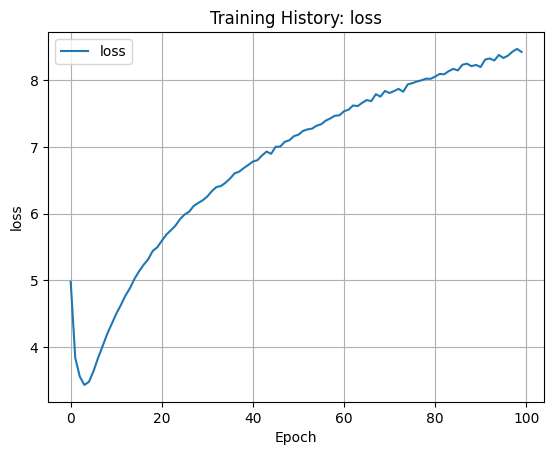

In [10]:
import pickle
import matplotlib.pyplot as plt

# === Step 1: Load history ===
pkl_path = "../vae_conv_jerkEvents_20_1752968377_trainingHistory.pkl"  # Replace with your actual file path

with open(pkl_path, "rb") as f:
    history = pickle.load(f)

# === Step 2: Show available metrics ===
print("Available metrics:")
for key in history.keys():
    print(f" - {key}")

# === Step 3: Plot training curves ===
def plot_metric(metric_name):
    if metric_name not in history:
        print(f"Metric '{metric_name}' not found.")
        return
    
    plt.plot(history[metric_name], label=f"{metric_name}")
    
    val_key = f"val_{metric_name}"
    if val_key in history:
        plt.plot(history[val_key], label=f"{val_key}")
    
    plt.title(f"Training History: {metric_name}")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

# === Step 4: Plot loss by default ===
plot_metric("loss")

# To plot other metrics:
# plot_metric("accuracy")
# plot_metric("mae")


------------ RUN id vae_lstm_jerkEvents_20_1753011176_trainingHistory.pkl------------


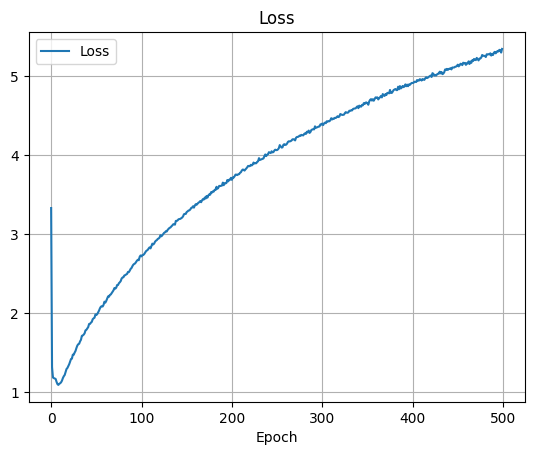

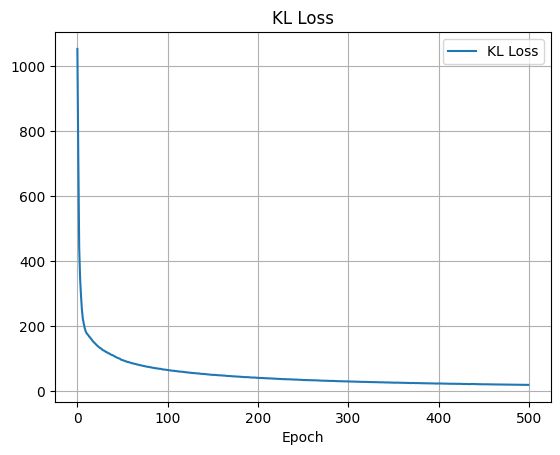

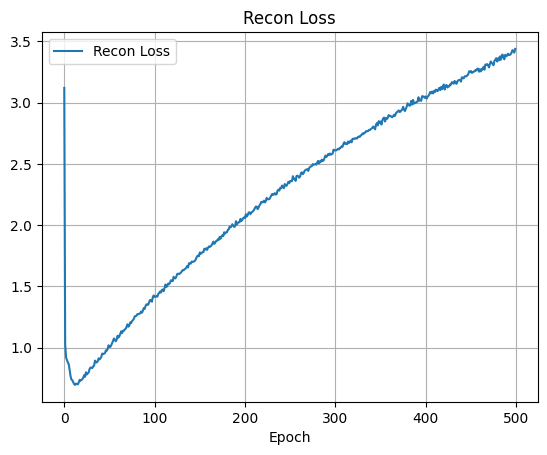

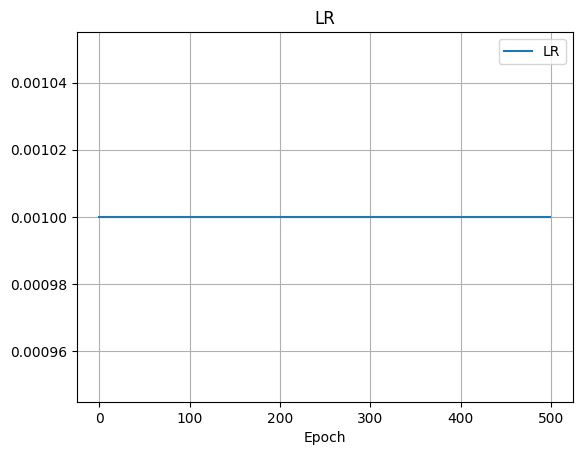

------------ RUN id vae_lstm_jerkEvents_20_1753017641_trainingHistory.pkl------------


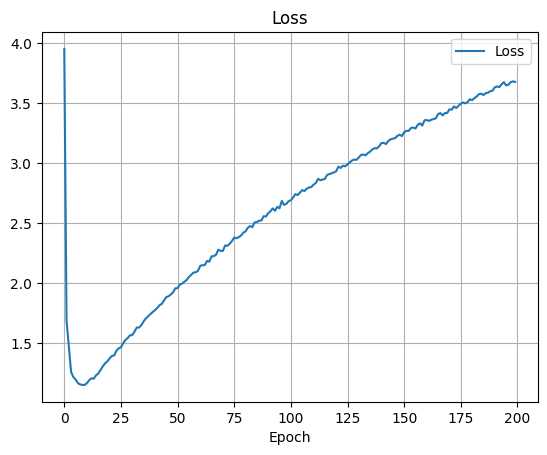

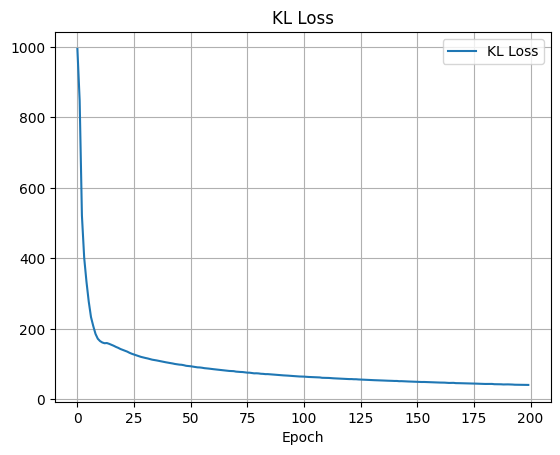

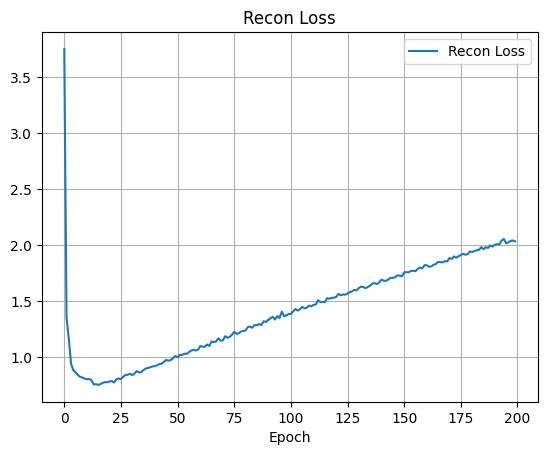

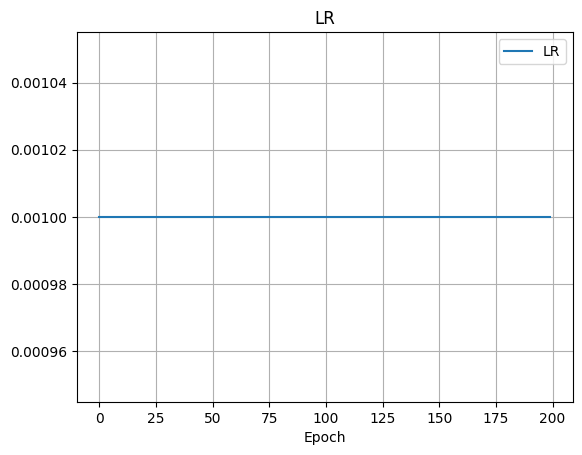

------------ RUN id vae_lstm_jerkEvents_20_1753021663_trainingHistory.pkl------------


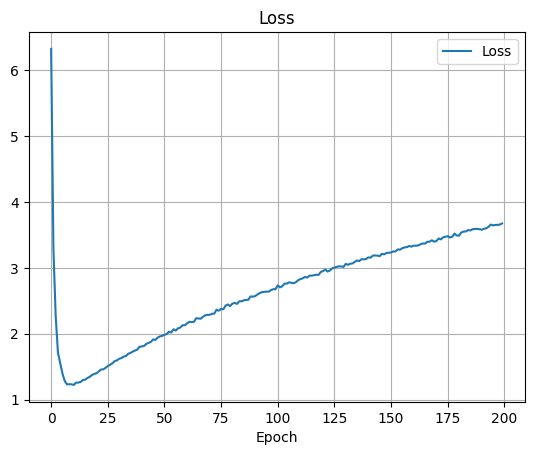

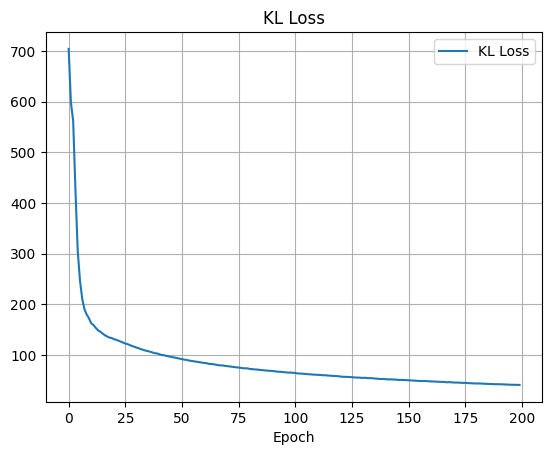

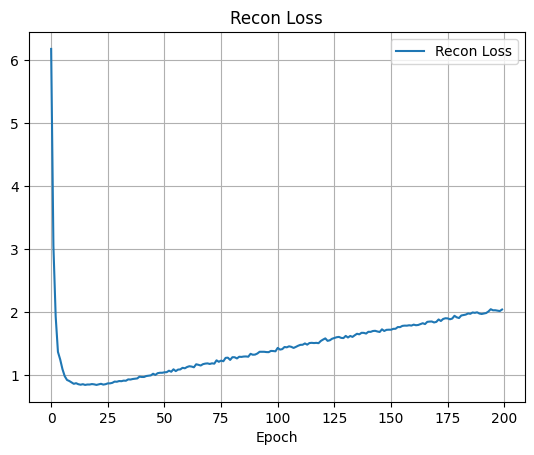

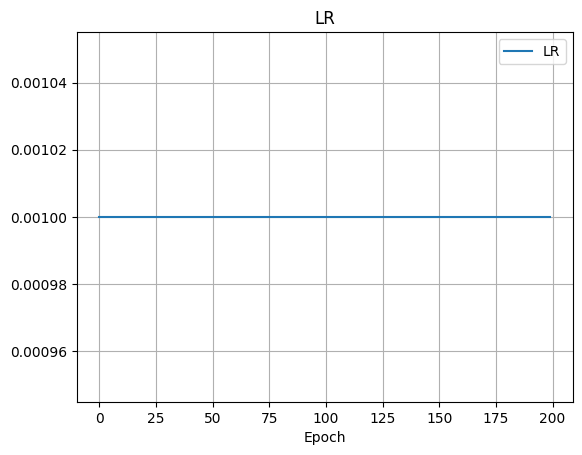

------------ RUN id vae_lstm_jerkEvents_20_1753029736_trainingHistory.pkl------------


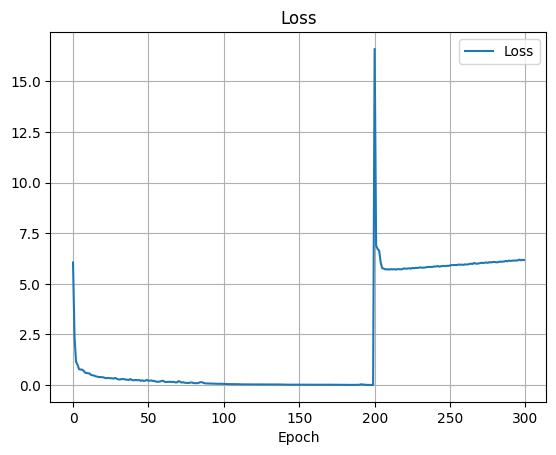

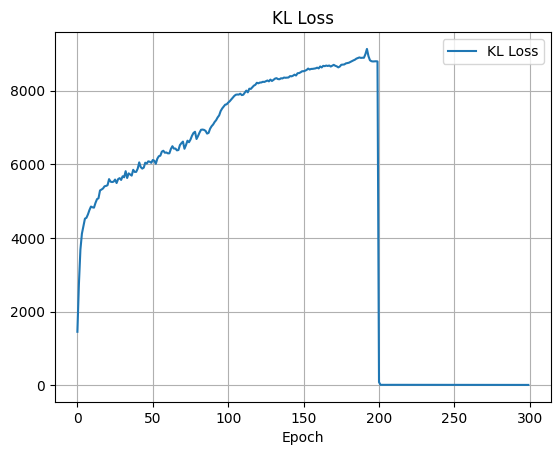

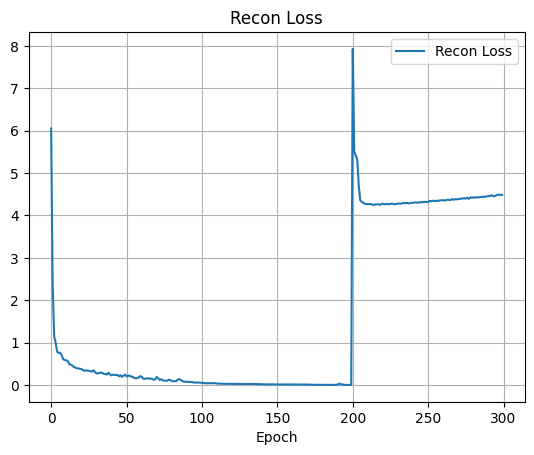

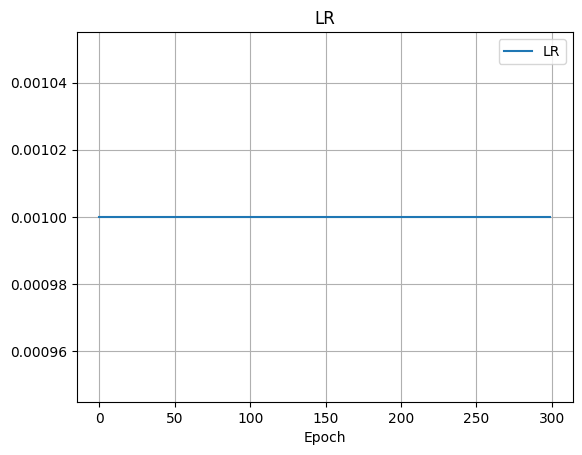

: 

In [ ]:
runs_10 = [path for path in os.listdir("../") if path.startswith("vae_lstm")]

for run in runs_10:
    pkl_path = f"../{run}"
    with open(pkl_path, "rb") as f:
        history = pickle.load(f)
    print(f"------------ RUN id {run}------------")
    evaluate_training_run(history)


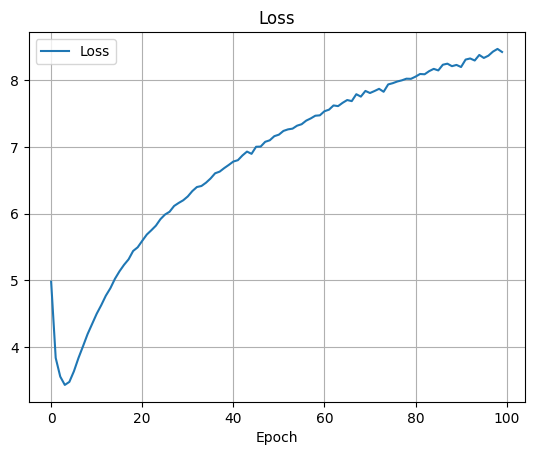

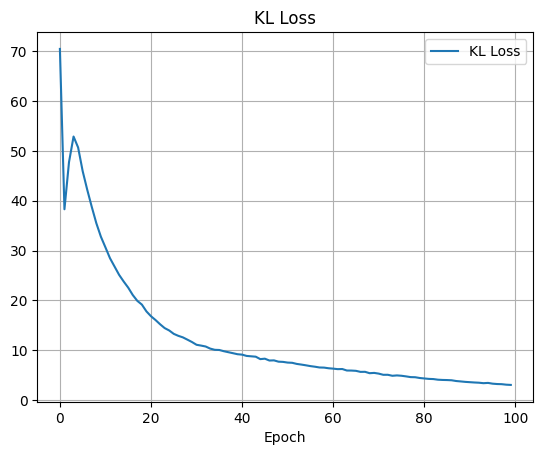

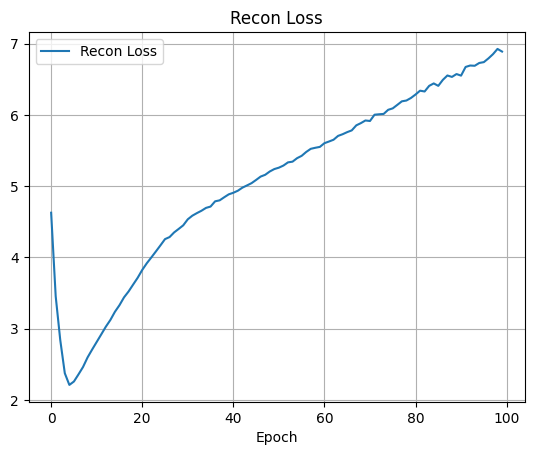

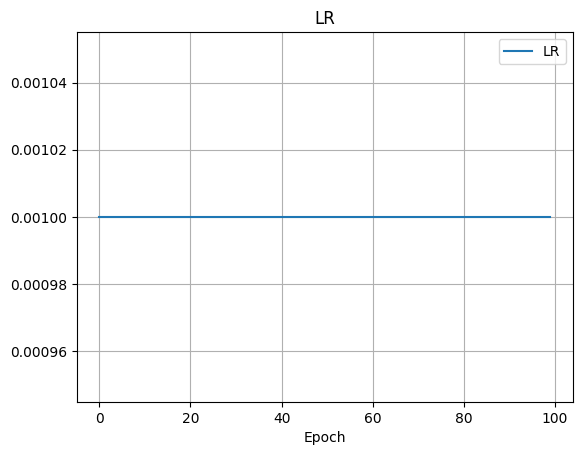

{'loss_plateau': False,
 'kl_plateau': False,
 'recon_plateau': False,
 'kl_collapse': False,
 'possible_overfit': False,
 'lr_final': 0.0010000000474974513,
 'lr_stable': True,
 'stability_score': 0.8}

In [ ]:

evaluate_training_run(history)

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def load_history(pkl_path):
    with open(pkl_path, "rb") as f:
        history = pickle.load(f)
    return history

def moving_avg(x, w=5):
    return np.convolve(x, np.ones(w)/w, mode='valid')

def evaluate_training_run(history, plot=True):
    results = {}
    
    # Extract metrics
    loss = np.array(history["loss"])
    kl = np.array(history["kl_loss"])
    recon = np.array(history["reconstruction_loss"])
    lr = np.array(history["learning_rate"])
    wt = np.array(history["reconstruction_wt"]) if "reconstruction_wt" in history else np.ones_like(loss)

    # === Plotting (Optional) ===
    if plot:
        for metric_name, metric in zip(["Loss", "KL Loss", "Recon Loss", "LR"], [loss, kl, recon, lr]):
            plt.figure()
            plt.plot(metric, label=metric_name)
            plt.title(metric_name)
            plt.xlabel("Epoch")
            plt.grid(True)
            plt.legend()
            plt.show()

    # === 1. Plateau Detection ===
    def has_plateau(metric, window=10, tol=1e-3):
        tail = moving_avg(metric, w=window)
        deltas = np.abs(np.diff(tail))
        return np.all(deltas[-window:] < tol)

    results["loss_plateau"] = has_plateau(loss)
    results["kl_plateau"] = has_plateau(kl)
    results["recon_plateau"] = has_plateau(recon)

    # === 2. KL Collapse ===
    results["kl_collapse"] = np.mean(kl[-10:]) < 1e-3

    # === 3. Overfitting Heuristic ===
    recon_grad = np.gradient(recon)
    kl_grad = np.gradient(kl)
    results["possible_overfit"] = recon_grad[-1] > -1e-3 and kl_grad[-1] > 0.01


    # === 5. Learning Rate Too High or Low ===
    results["lr_final"] = lr[-1]
    results["lr_stable"] = np.std(lr[-10:]) < 1e-6 or np.allclose(lr[-1], lr[0])

    # === 6. General Convergence Score (0–1) ===
    stability_score = 1.0
    if results["kl_collapse"]: stability_score -= 0.3
    if results["possible_overfit"]: stability_score -= 0.2
    if not results["loss_plateau"]: stability_score -= 0.2
    results["stability_score"] = round(max(0.0, stability_score), 3)

    return results
